In [1]:
import sklearn

from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>")) # Increase cell width
display(HTML("<style>.rendered_html { font-size: 16px; }</style>")) # Increase font size

# Figures
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

import pandas as pd
import numpy as np
import itertools
from collections import defaultdict

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
import matplotlib.pyplot as plt

## Useful functions

In [3]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    
    plt.xticks(tick_marks, classes.tolist(), rotation=45)
    plt.yticks(tick_marks, classes.tolist())
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 verticalalignment='center',
                 color="white" if cm[i, j] > thresh else "black")

    plt.xlim(-0.5, len(classes)-0.5)
    plt.ylim(len(classes)-0.5, -0.5)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def train_model(X,y, model, show_figures=True): 
    y_pred = cross_val_predict(model, X, y, cv=5)
    conf_mat = confusion_matrix(y, y_pred)
    score = accuracy_score(y,y_pred)
    print("Accuracy = {0:.4f}".format(score))
    if show_figures:
        plot_confusion_matrix(conf_mat, y.unique())
        model.fit(X, y)
        get_feature_importance(model, X.columns, n_features=28)
    return model, score

def get_feature_importance(clf, features, n_features):
    feature_importance = abs(clf.coef_[0])
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)[:n_features]
    pos = np.arange(sorted_idx.shape[0]) + .5

    featfig = plt.figure(figsize=(10,10))
    featfig.suptitle(str(n_features) + " Most important features")
    featax = featfig.add_subplot(1, 1, 1)
    featax.barh(pos, feature_importance[sorted_idx], align='center')
    featax.set_yticks(pos)
    featax.set_xticks([])
    featax.set_yticklabels(np.array(features), fontsize=15)
    featax.set_xlabel('Relative Feature Importance', fontsize=15)
    plt.show()

## Reading and preparation

In [4]:
training = pd.read_csv("final_training.csv", delimiter=",", decimal=".")
test = pd.read_csv("test.csv", delimiter=",", decimal=".")

In [5]:
test

,Unnamed: 0,Id_Cliente,Ano,Curso,Asignatura,TipoMaterial,Lengua,TipoSoporte,Clase,ValorClase,art_id,GrupoEditorialPrevio,Latitud,Longitud,ComunidadAutonoma,Titularidad
0,0,113956,2019,33,48,3,13,1,150.0,22.5150,11395633483131,10.0,42.852859,-2.668525,7,1
1,1,113956,2019,33,65,1,26,1,90.0,22.1760,11395633651261,90.0,42.852859,-2.668525,7,1
2,2,113956,2019,32,8,1,26,2,96.0,12.8640,1139563281262,3.0,42.852859,-2.668525,7,1
3,3,113956,2019,32,60,1,26,2,68.0,9.1188,11395632601262,1.0,42.852859,-2.668525,7,1
4,4,113956,2019,32,73,1,13,2,53.0,7.1020,11395632731132,90.0,42.852859,-2.668525,7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
617855,617855,212536,2019,36,48,1,13,1,99.0,46.7181,21253636481131,4.0,41.384132,2.046094,1,1
617856,617856,212536,2019,36,42,1,13,1,10.0,3.5420,21253636421131,2.0,41.384132,2.046094,1,1
617857,617857,212536,2019,36,8,1,10,1,40.0,14.1360,2125363681101,16.0,41.384132,2.046094,1,1
617858,617858,212536,2019,37,48,2,13,1,80.0,8.2720,21253637482131,4.0,41.384132,2.046094,1,1


In [6]:
training = training.drop(['Unnamed: 0'],axis=1)
training = training.drop(['Ano'],axis=1)
training = training.drop(['GrupoEditorialActual'], axis = 1)
training = training.drop(['Longitud'], axis = 1)
training = training.drop(['Latitud'], axis = 1)
test = test.drop(['Unnamed: 0'],axis=1)
test = test.drop(['Ano'],axis=1)
test = test.drop(['Longitud'], axis = 1)
test = test.drop(['Latitud'], axis = 1)

In [7]:
pd.options.display.max_columns = training.shape[1] # It prints the info in all the columns

training.describe()

,art_id,Id_Cliente,Curso,Asignatura,TipoMaterial,GrupoEditorialPrevio,Lengua,TipoSoporte,Target,Clase,ValorClase,ComunidadAutonoma,Titularidad
count,7.646280e+05,764628.000000,764628.000000,764628.000000,764628.000000,764628.000000,764628.000000,764628.000000,764628.000000,764628.000000,764628.000000,764628.000000,764628.000000
mean,2.584881e+13,153829.429379,30.353170,67.919871,1.267135,33.004016,13.663486,1.023880,0.027722,44.966939,975.758634,3.098355,2.450310
std,3.796110e+13,27145.744317,3.757106,57.337341,0.656809,38.788173,3.731584,0.152674,0.164175,37.085171,943.063562,2.016503,0.795442
min,1.139563e+12,113956.000000,20.000000,1.000000,1.000000,1.000000,10.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,1.320993e+13,132119.000000,27.000000,48.000000,1.000000,3.000000,13.000000,1.000000,0.000000,21.000000,379.800000,1.000000,2.000000
50%,1.661044e+13,163111.000000,30.000000,54.000000,1.000000,8.000000,13.000000,1.000000,0.000000,36.000000,717.860000,2.000000,3.000000
75%,1.745914e+13,172936.000000,34.000000,65.000000,1.000000,90.000000,13.000000,1.000000,0.000000,57.000000,1304.920000,5.000000,3.000000
max,2.118173e+14,211817.000000,37.000000,280.000000,4.000000,90.000000,26.000000,2.000000,1.000000,1540.000000,34617.440000,7.000000,3.000000


## Data cleaning

### Dummy re-encoding

In [8]:
training.dtypes

art_id                    int64
Id_Cliente                int64
Curso                     int64
Asignatura                int64
TipoMaterial              int64
GrupoEditorialPrevio    float64
Lengua                    int64
TipoSoporte               int64
Target                  float64
Clase                   float64
ValorClase              float64
ComunidadAutonoma         int64
Titularidad               int64
dtype: object

In [9]:
# check data types
# if object -> as category
categorical_columns = ['Curso', 'Asignatura','TipoMaterial', 'Lengua', 'ComunidadAutonoma', 'Titularidad', 'GrupoEditorialPrevio', 'Id_Cliente','TipoSoporte']

training[categorical_columns] = training[categorical_columns].astype("category")
training.dtypes

art_id                     int64
Id_Cliente              category
Curso                   category
Asignatura              category
TipoMaterial            category
GrupoEditorialPrevio    category
Lengua                  category
TipoSoporte             category
Target                   float64
Clase                    float64
ValorClase               float64
ComunidadAutonoma       category
Titularidad             category
dtype: object

In [10]:
test[categorical_columns] = test[categorical_columns].astype("category")
test.dtypes

Id_Cliente              category
Curso                   category
Asignatura              category
TipoMaterial            category
Lengua                  category
TipoSoporte             category
Clase                    float64
ValorClase               float64
art_id                     int64
GrupoEditorialPrevio    category
ComunidadAutonoma       category
Titularidad             category
dtype: object

In [11]:
numerical_cols = training.columns[training.dtypes!='category'].tolist()

## For splitting our data  +    Balancing the data 

In [12]:
# Class count
count_class_0, count_class_1 = training.Target.value_counts()

# Divide by class
df_class_0 = training[training['Target'] == 0.0]
df_class_1 = training[training['Target'] == 1.0]

Random under-sampling:
1.0    21197
0.0    21197
Name: Target, dtype: int64


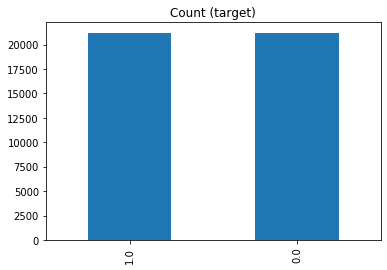

In [13]:
df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.Target.value_counts())

df_test_under.Target.value_counts().plot(kind='bar', title='Count (target)');

In [14]:
bal_training = df_class_0_under.append(df_class_1)

In [15]:
from sklearn.model_selection import train_test_split

X = bal_training.drop(columns=(['art_id','Target']))
y = bal_training['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Baseline model

Accuracy = 0.6037


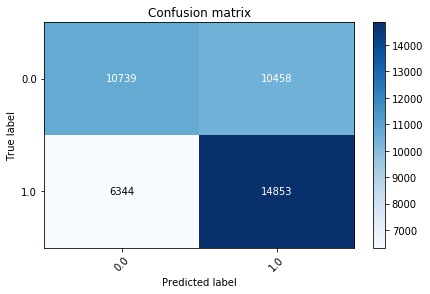

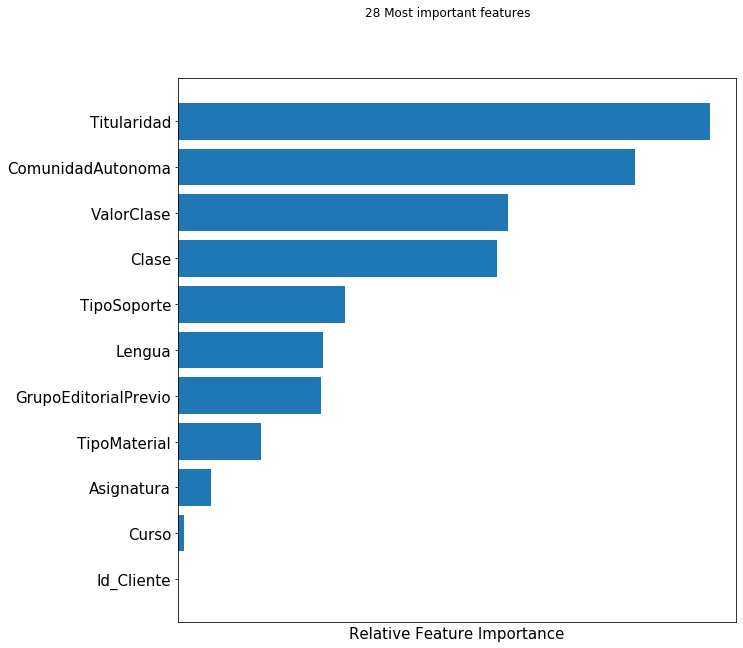

In [16]:
baseline_model, score = train_model(X, y, linear_model.LogisticRegression(max_iter=10000, penalty='none', solver = 'lbfgs'))

In [17]:
results_df = pd.DataFrame(columns=['Approach', 'Accuracy'])
results_df.loc[len(results_df)] = ['LR Baseline', score]
results_df

,Approach,Accuracy
0,LR Baseline,0.60367


#### Random Forest

In [18]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier


model = RandomForestClassifier(random_state= 101).fit(X_train,y_train)
predictionforest = model.predict(X_test)
print(confusion_matrix(y_test,predictionforest))
print(classification_report(y_test,predictionforest))
acc1 = accuracy_score(y_test,predictionforest)

[[5491 1513]
 [ 775 6212]]
              precision    recall  f1-score   support

         0.0       0.88      0.78      0.83      7004
         1.0       0.80      0.89      0.84      6987

    accuracy                           0.84     13991
   macro avg       0.84      0.84      0.84     13991
weighted avg       0.84      0.84      0.84     13991



In [19]:
acc1 = accuracy_score(y_test,predictionforest)
acc1

0.8364662997641341

## Outliers

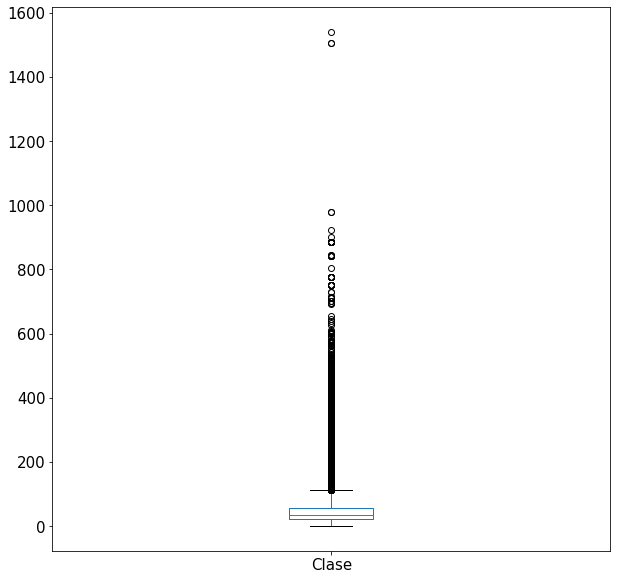

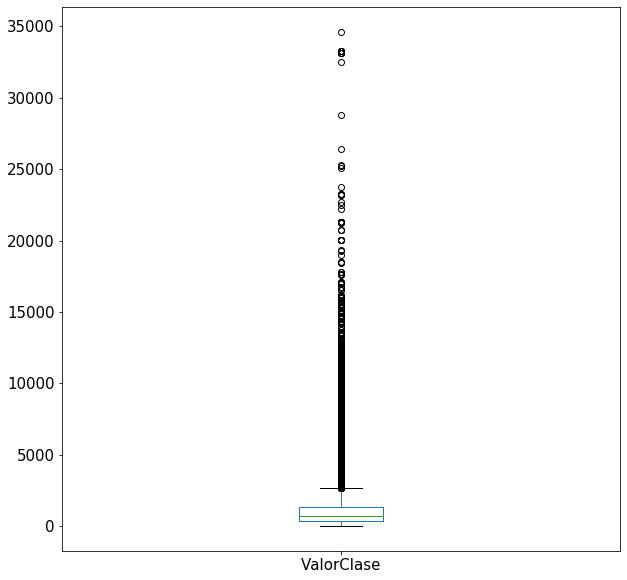

In [20]:
plt.figure(figsize=(10,10))
training.boxplot(['Clase'], grid=False, fontsize=15)

plt.figure(figsize=(10,10))
training.boxplot(['ValorClase'], grid=False, fontsize=15)


In [21]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    print("{} outliers removed".format(len(df_in)-len(df_out)))
    return df_out

In [22]:
training = remove_outlier(training,'Clase')

training = remove_outlier(training,'ValorClase')

41332 outliers removed
23208 outliers removed


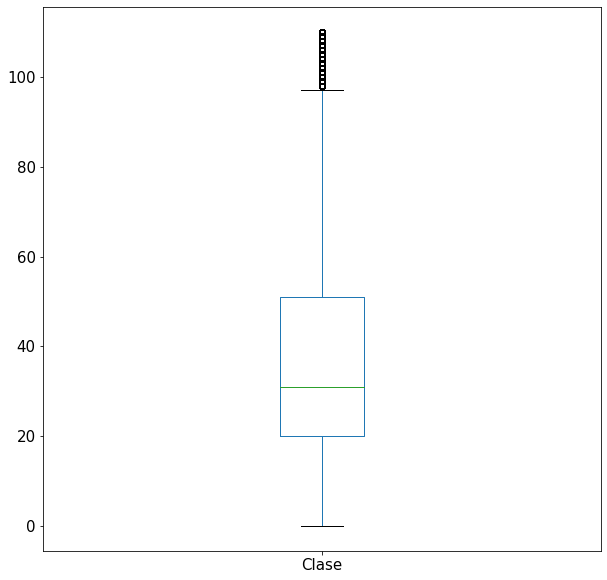

In [23]:
plt.figure(figsize=(10,10))
training.boxplot(['Clase'], grid=False, fontsize=15)

### baseline model without outliers

In [24]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier


model = RandomForestClassifier(random_state= 101).fit(X_train,y_train)
predictionforest = model.predict(X_test)
print(confusion_matrix(y_test,predictionforest))
print(classification_report(y_test,predictionforest))
acc1 = accuracy_score(y_test,predictionforest)

[[5491 1513]
 [ 775 6212]]
              precision    recall  f1-score   support

         0.0       0.88      0.78      0.83      7004
         1.0       0.80      0.89      0.84      6987

    accuracy                           0.84     13991
   macro avg       0.84      0.84      0.84     13991
weighted avg       0.84      0.84      0.84     13991



In [25]:
acc1

0.8364662997641341

## Feature engineering

### Feature creation

In [27]:
# create the feature test the model with the new feature

In [28]:
def unit_price(dataframe):
    unit_price = []
    unit_price = dataframe.ValorClase/dataframe.Clase
    unit_price = pd.DataFrame(unit_price, columns = ['unit_price'])
    dataframe = pd.concat([dataframe.reset_index(drop=True), unit_price.reset_index(drop=True)], axis=1)
    return dataframe

In [29]:
bal_training = unit_price(bal_training)
test = unit_price(test)

In [30]:
bal_training = bal_training.drop(['Clase', 'ValorClase'], axis = 1)
test = test.drop(['Clase', 'ValorClase'], axis = 1)

In [31]:
bal_training = bal_training.dropna(how='any',axis=0)
test = test.dropna(how='any',axis=0)

In [32]:
bal_training.isna().sum()

art_id                  0
Id_Cliente              0
Curso                   0
Asignatura              0
TipoMaterial            0
GrupoEditorialPrevio    0
Lengua                  0
TipoSoporte             0
Target                  0
ComunidadAutonoma       0
Titularidad             0
unit_price              0
dtype: int64

In [33]:
test.isna().sum()

Id_Cliente              0
Curso                   0
Asignatura              0
TipoMaterial            0
Lengua                  0
TipoSoporte             0
art_id                  0
GrupoEditorialPrevio    0
ComunidadAutonoma       0
Titularidad             0
unit_price              0
dtype: int64

### redefine X and y

In [34]:
from sklearn.model_selection import train_test_split

X = bal_training.drop(columns=(['art_id','Target']))
y = bal_training['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Re -run the model with the new feature

In [35]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier


model = RandomForestClassifier(random_state= 101).fit(X_train,y_train)
predictionforest = model.predict(X_test)
print(confusion_matrix(y_test,predictionforest))
print(classification_report(y_test,predictionforest))
acc1 = accuracy_score(y_test,predictionforest)

[[5458 1527]
 [ 967 6014]]
              precision    recall  f1-score   support

         0.0       0.85      0.78      0.81      6985
         1.0       0.80      0.86      0.83      6981

    accuracy                           0.82     13966
   macro avg       0.82      0.82      0.82     13966
weighted avg       0.82      0.82      0.82     13966



In [36]:
acc1

0.8214234569669197

### Cross Validation

In [37]:
from sklearn.model_selection import GridSearchCV
param_grid = {'max_depth': range(1,16)}

model_pruned_cv = GridSearchCV(model, 
                   param_grid,
                   scoring='accuracy',
                   cv=5 , n_jobs=1, verbose=1)

model_pruned_cv.fit(X_train,y_train)


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:  1.3min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=101,
                                 

In [38]:
predictionforest = model_pruned_cv.predict(X_test)
print(confusion_matrix(y_test,predictionforest))
print(classification_report(y_test,predictionforest))
acc1 = accuracy_score(y_test,predictionforest)

[[5070 1915]
 [ 625 6356]]
              precision    recall  f1-score   support

         0.0       0.89      0.73      0.80      6985
         1.0       0.77      0.91      0.83      6981

    accuracy                           0.82     13966
   macro avg       0.83      0.82      0.82     13966
weighted avg       0.83      0.82      0.82     13966



### Running the Final model over all the Training Data

In [ ]:
# test = test.dropna()

In [39]:
model = RandomForestClassifier(random_state= 101).fit(X ,y)
predictionforest = model.predict(test.drop(["art_id"], axis = 1))


### PREDICTIONS

In [40]:
predictions = pd.DataFrame({'id':test['art_id'], 'Target':predictionforest})
predictions.to_csv("predictions.csv", index=False)